In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
from matplotlib import pyplot as plt
from keplergl import KeplerGl

%matplotlib inline
plt.rcParams["figure.figsize"] = (16,8)
plt.rc("font", size=15)
plt.tight_layout()

print("Pandas Version: " + pd.__version__)
print("Numpy Version: " + np.__version__)
print("Seaborn Version: " + sns.__version__)

Pandas Version: 1.2.4
Numpy Version: 1.18.5
Seaborn Version: 0.11.1


<Figure size 1152x576 with 0 Axes>

In [3]:
trips = pd.read_csv("../../data/clean/trips.csv", parse_dates=["date_from", "date_until"])
trips.sample(3)

,bike_id,user_id,date_from,date_until,start_station_name,start_station_id,end_station_name,end_station_id,booked_via,duration_in_min,distance_in_km,speed_in_kmh,time_since_last_checkout
7389890,106159,C91AD881F28F543C41575AC4ED65D4B72B5C58C8,2017-04-18 16:58:56,2017-04-18 17:14:50,Große Bergstraße / Jessenstraße,131649,Schulterblatt/Eifflerstraße,131648,Android SRH,16,1.630771,6.115391,4 days 15:56:03
6691915,119956,72AC4E6B28C13470963706C49ACBE536AA328C39,2016-12-07 16:01:05,2016-12-07 16:12:06,Emilienstraße/Fruchtallee,213825,Allende-Platz/Grindelhof,198077,Android SRH,12,2.006505,10.032523,5 days 03:47:51
3907701,115783,E8F88557F3BE8DAB25A9EF0B8B3BC4B3C1FFEFE6,2015-10-28 14:04:27,2015-10-28 14:13:46,Neunenfelder Straße/ Kurt-Emmerich-Platz,226607,Mannesallee/Veringstraße,199402,Android SRH,10,2.190608,13.143647,0 days 02:28:42


In [4]:
stations = pd.read_csv("../../data/clean/stations.csv")
coordinates = stations[["name", "latitude", "longitude"]].set_index("name")
stations.sample(3)

,station_id,name,longitude,latitude
187,252499,Manshardtstraße/EKZ Manshardtstraße,10.107447,53.559215
52,139498,Chemnitzstraße / Max-Brauer-Allee,9.942860,53.555300
171,250340,Hugo-Kirchberg-Straße/Tesa,9.985280,53.654290


In [5]:
trips_per_hour = pd.read_csv("../../data/clean/trips_hourly.csv", parse_dates=["datetime"])
trips_per_hour.set_index("datetime", inplace=True)
trips_per_hour.sample(3)

,station_name,check_ins,check_outs,diff
datetime,,,,
2015-10-17 18:00:00,Messehallen / Marktstraße,3,6,-3
2016-08-19 16:00:00,Röntgenstraße/Philips,0,1,-1
2014-01-07 18:00:00,Am Kaiserkai/Großer Grasbrook,3,17,-14


In [6]:
# Read position of public transport stations and lines from esri data sets

pt_stations = gpd.read_file("../../data/esri/pt_stations.geojson")
pt_lines = gpd.read_file("../../data/esri/pt_lines.geojson")

In [7]:
# Set some date variables

FIRST_DAY = "2014-01-07"
LAST_COMPLETE_DAY = "2017-05-14 23:59:59"

In [8]:
# Collect all station names that are present throughout the whole trip data set

first_month_stations = pd.unique(
    trips[trips.date_from <= pd.Timestamp("2014-01-31 23:59:59")].start_station_name
)

## Heatmap: Check-ins and check-outs per hour

In [9]:
# Group station movements per hour and station and reformat for kepler

stations_hourly_movements = trips_per_hour.groupby([trips_per_hour.index.hour, "station_name"]).sum()
stations_hourly_movements = stations_hourly_movements.merge(
    coordinates, left_on="station_name", right_index=True, sort=False
).reset_index()
stations_hourly_movements.to_csv("../../data/kepler/stations_hourly_movements.csv", index=False)
stations_hourly_movements

,datetime,station_name,check_ins,check_outs,diff,latitude,longitude
0,0,Allende-Platz/Grindelhof,3723,4582,-859,53.567845,9.982728
1,1,Allende-Platz/Grindelhof,2912,3053,-141,53.567845,9.982728
2,2,Allende-Platz/Grindelhof,1992,1716,276,53.567845,9.982728
3,3,Allende-Platz/Grindelhof,1612,921,691,53.567845,9.982728
4,4,Allende-Platz/Grindelhof,1251,578,673,53.567845,9.982728
...,...,...,...,...,...,...,...
4987,19,Überseering/Mexikoring,840,1000,-160,53.601619,10.024745
4988,20,Überseering/Mexikoring,539,745,-206,53.601619,10.024745
4989,21,Überseering/Mexikoring,351,652,-301,53.601619,10.024745
4990,22,Überseering/Mexikoring,235,349,-114,53.601619,10.024745


In [10]:
stations_hourly_movements["datetime"] = pd.to_datetime(
    pd.DataFrame({"year": 2015, "month": 10, "day": 30, "hour": stations_hourly_movements["datetime"]})
)

In [11]:
KeplerGl(
    height=700, 
    data={
        "data": stations_hourly_movements,
    },
    config=eval(
        open("../../config/map_hourly_stations_activity.py", "r").read()
    )
)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['data'], 'id': 'k3htm9tg2', …

## Plot daily mean amount of check-ins, check-outs and their difference

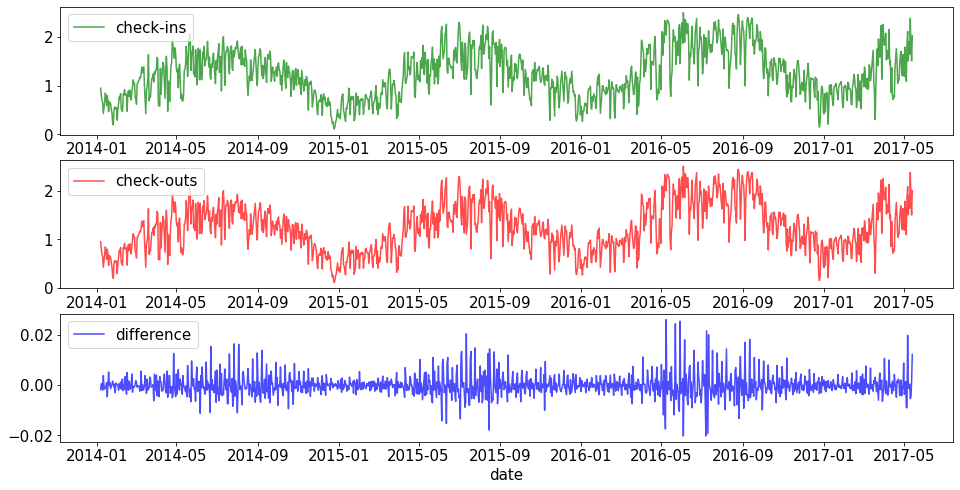

In [12]:
daily_mean = trips_per_hour[
    pd.Timestamp(FIRST_DAY):pd.Timestamp(LAST_COMPLETE_DAY)
].resample("D").mean()

fig, ax = plt.subplots(3, 1)
ax[0].plot(daily_mean["check_ins"], color="green", label="check-ins", alpha=0.7)
ax[0].legend()
ax[1].plot(daily_mean["check_outs"], color="red", label="check-outs", alpha=0.7)
ax[1].legend()
ax[2].plot(daily_mean["diff"], color="blue", label="difference", alpha=0.7)
ax[2].legend()
plt.xlabel("date")
plt.savefig("../../figures/stations_daily_mean.pdf", bbox_inches="tight")
plt.show()

## Examine overall inventory change per station

In [13]:
start_count = trips.value_counts(subset=["start_station_id"]).to_frame()
start_count.rename(columns={0: "check_outs"}, inplace=True)

end_count = trips.value_counts(subset=["end_station_id"]).to_frame()
end_count.rename(columns={0: "check_ins"}, inplace=True)

stations_count = stations.merge(start_count, left_on="station_id", right_index=True, sort=False)
stations_count = stations_count.merge(end_count, left_on="station_id", right_index=True, sort=False)
stations_count["diff"] = stations_count.apply(lambda x: x["check_ins"] - x["check_outs"], axis=1)
stations_count = stations_count.sort_values(by="diff", ascending=True)

stations_count

,station_id,name,longitude,latitude,check_outs,check_ins,diff
19,131872,Hauptbahnhof West / Glockengießer Wall,10.004553,53.553676,94646,80907,-13739
20,131873,Hauptbahnhof Ost / Hachmannplatz,10.007652,53.554307,96983,86420,-10563
32,131889,Bahnhof Altona West / Busbahnhof,9.933870,53.551800,70642,62699,-7943
108,213679,U-Bahn Schlump,9.969601,53.567991,68568,62426,-6142
16,131652,Berliner Tor / Berlinertordamm,10.024600,53.553300,79654,73947,-5707
...,...,...,...,...,...,...,...
119,218173,Rothenburgsort/Marktplatz/Lindleystraße,10.038938,53.534288,20569,25532,4963
23,131879,Jungfernstieg / Ballindamm,9.995501,53.552244,107754,113539,5785
0,131543,Landungsbrücke/Hafentor,9.972300,53.545700,89663,95542,5879
78,199402,Mannesallee/Veringstraße,9.987298,53.514265,20701,27388,6687


In [14]:
stations_count.describe()

,station_id,longitude,latitude,check_outs,check_ins,diff
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,199879.750000,10.001020,53.557640,36567.201923,36567.201923,0.000000
std,48626.097309,0.057762,0.036847,32142.215813,32244.461661,2187.707524
min,131543.000000,9.862013,53.447625,81.000000,72.000000,-13739.000000
25%,139220.750000,9.969232,53.548219,8936.250000,9031.750000,-424.250000
50%,212078.500000,9.993834,53.559731,28649.000000,28334.000000,15.000000
75%,244939.750000,10.028767,53.578009,56025.750000,57382.250000,477.000000
max,268358.000000,10.220000,53.654290,157111.000000,160339.000000,9699.000000


In [15]:
# Save as separate data sets to display different colours in kepler

stations_positive_count = stations_count[stations_count["diff"] >= 0]
stations_negative_count = stations_count[stations_count["diff"] < 0]

stations_positive_count.to_csv("../../data/kepler/stations_overall_positive_diff.csv", index=False)
stations_negative_count.to_csv("../../data/kepler/stations_overall_negative_diff.csv", index=False)

In [16]:
stations_positive_count.describe()

,station_id,longitude,latitude,check_outs,check_ins,diff
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000
mean,200760.028302,10.008577,53.561418,40379.141509,41497.867925,1118.726415
std,48195.519999,0.059438,0.037576,35606.794918,36310.503617,1625.070580
min,131543.000000,9.862013,53.447625,768.000000,979.000000,6.000000
25%,140794.500000,9.978555,53.547684,7824.000000,8238.750000,180.250000
50%,212000.000000,9.999568,53.566472,33746.000000,34766.000000,459.500000
75%,245138.750000,10.034036,53.583098,64252.250000,64747.500000,1323.500000
max,264821.000000,10.210913,53.648757,157111.000000,160339.000000,9699.000000


In [17]:
stations_positive_count.median()

station_id    212000.000000
longitude          9.999568
latitude          53.566472
check_outs     33746.000000
check_ins      34766.000000
diff             459.500000
dtype: float64

In [18]:
stations_negative_count.describe()

,station_id,longitude,latitude,check_outs,check_ins,diff
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,198964.950980,9.993167,53.553715,32605.774510,31443.176471,-1162.598039
std,49290.871966,0.055163,0.035837,27717.047673,26611.688339,2094.062139
min,131640.000000,9.862160,53.448960,81.000000,72.000000,-13739.000000
25%,138382.250000,9.957085,53.549829,9805.000000,9624.000000,-1334.500000
50%,212921.000000,9.987697,53.556804,24318.000000,22704.500000,-444.000000
75%,244724.500000,10.022064,53.571568,47355.500000,46929.750000,-142.500000
max,268358.000000,10.220000,53.654290,107718.000000,107716.000000,-1.000000


In [19]:
stations_negative_count.median()

station_id    212921.000000
longitude          9.987697
latitude          53.556804
check_outs     24318.000000
check_ins      22704.500000
diff            -444.000000
dtype: float64

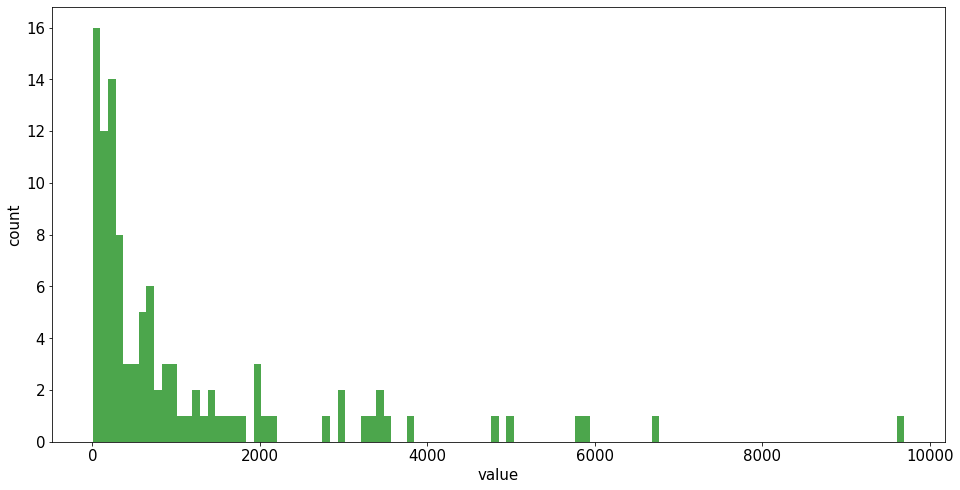

In [20]:
# Examine distribution of positive values

tmp = stations_count[stations_count["diff"] >= 0][["diff"]]
plt.hist(tmp, len(tmp), density=False, color="green", alpha=0.7)
plt.xlabel("value")
plt.ylabel("count")
plt.savefig("../../figures/stations_diff_positive_dist.pdf", bbox_inches="tight")
plt.show()

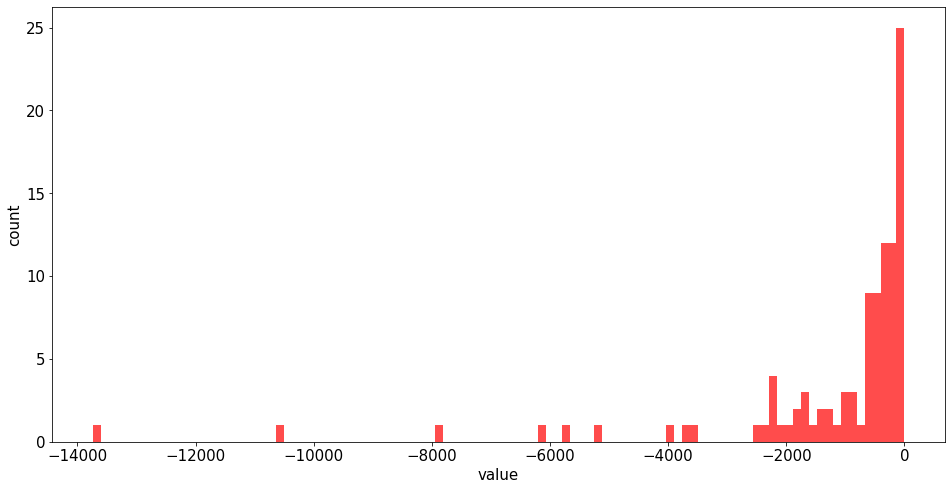

In [21]:
# Examine distribution of negative values

tmp = stations_count[stations_count["diff"] < 0][["diff"]]
plt.hist(tmp, len(tmp), density=False, color="red", alpha=0.7)
plt.xlabel("value")
plt.ylabel("count")
plt.savefig("../../figures/stations_diff_negative_dist.pdf", bbox_inches="tight")
plt.show()

In [22]:
KeplerGl(
    height=700, 
    data={
        "positive": stations_positive_count,
        "negative": stations_negative_count,
    },
    config=eval(
        open("../../config/map_overall_inventory_diff.py", "r").read()
    )
)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'rf7j5ch', 'type': …

## Examining the stations with the lowest and highest difference in inventory overall

In [23]:
grouped_by_station = trips_per_hour.groupby("station_name")

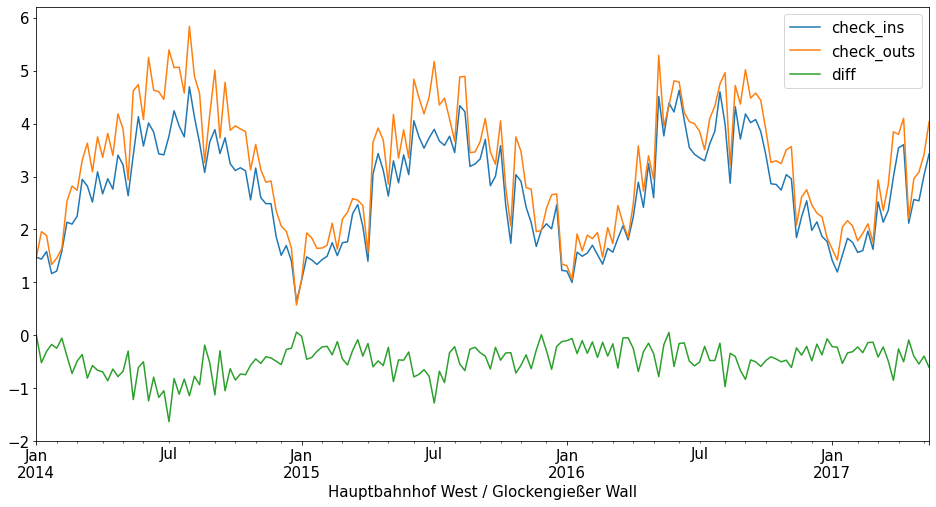

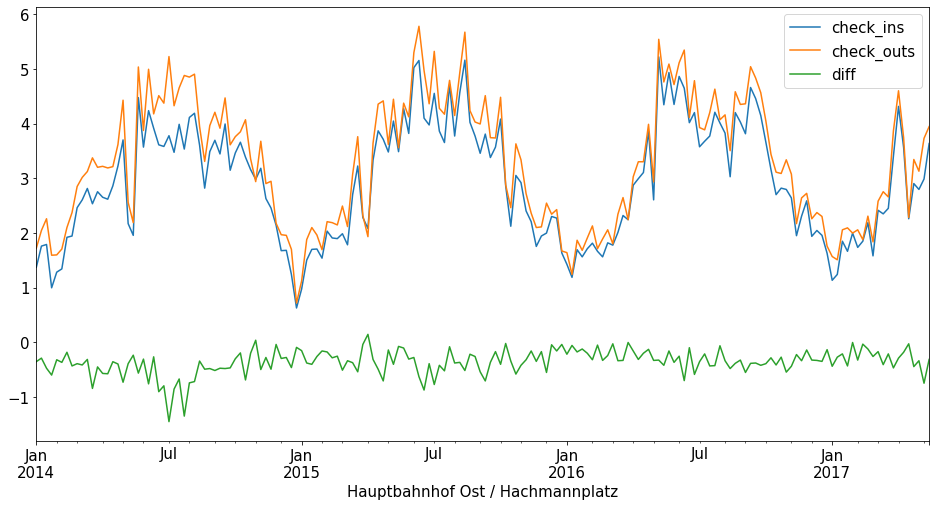

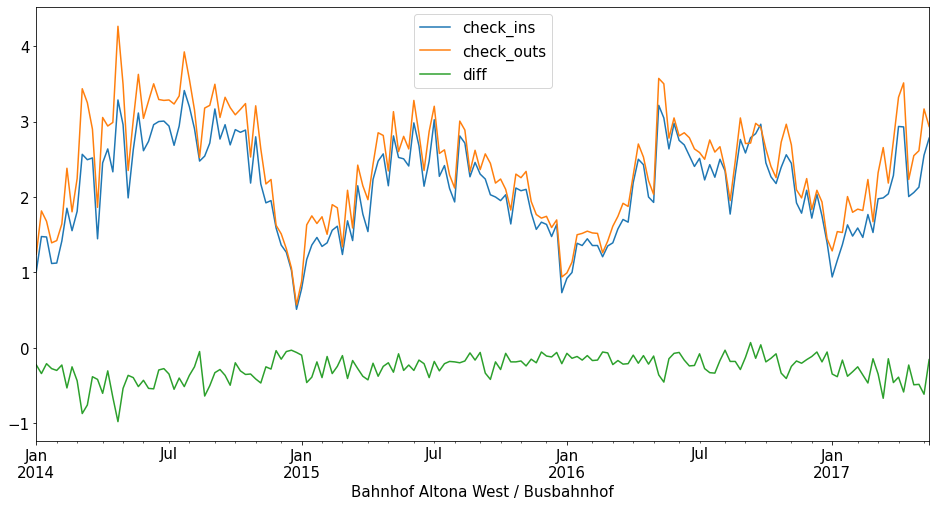

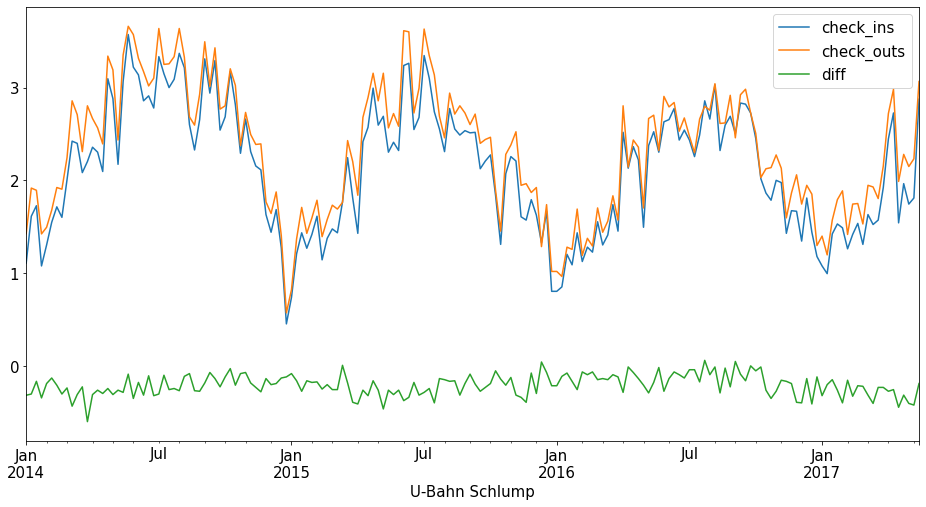

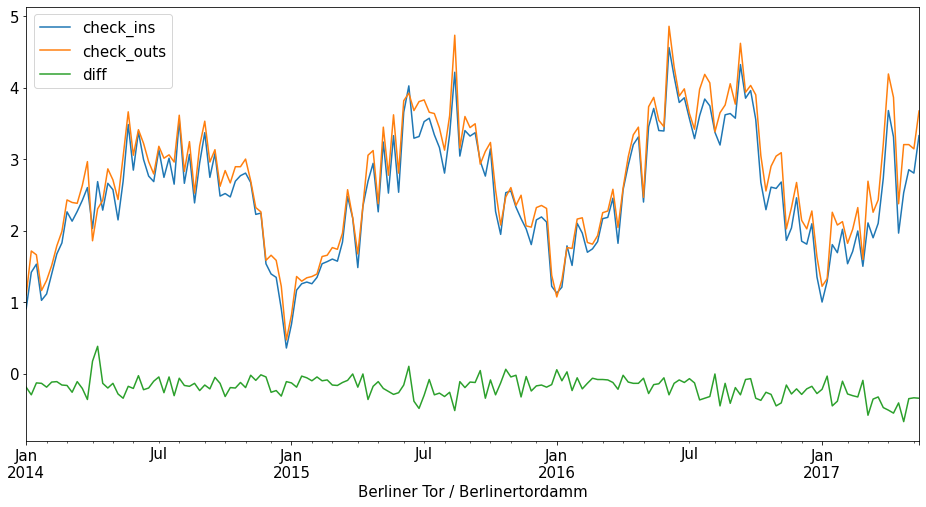

In [24]:
lowest_diff = stations_count.head(5)

for station_name in lowest_diff.name:
    tmp = grouped_by_station.get_group(station_name).resample("W").agg("mean")
    ax = tmp.iloc[:-1][["check_ins", "check_outs", "diff"]].plot.line()
    ax.set_xlabel(station_name)
    plt.show()

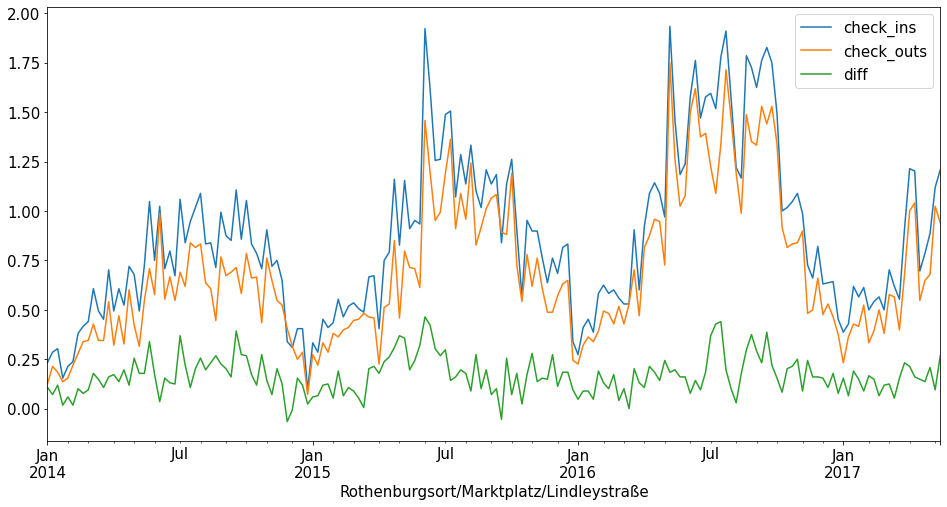

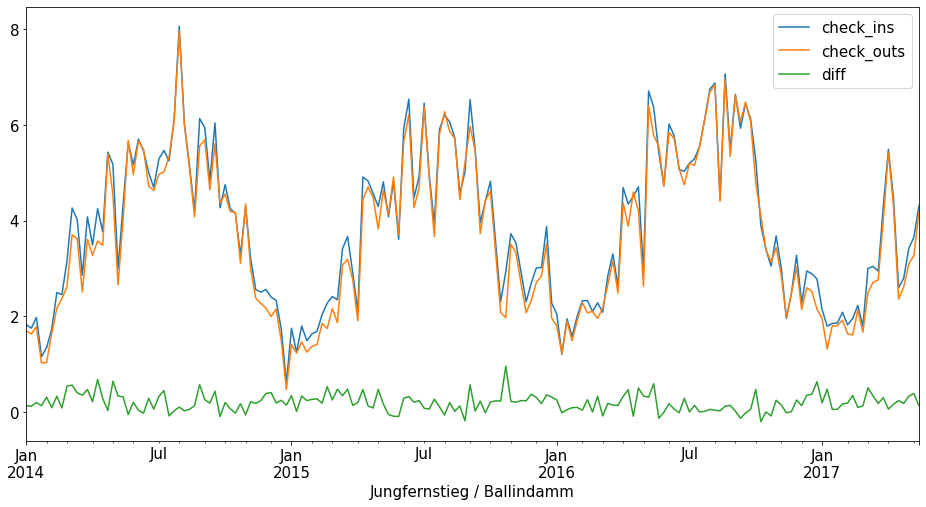

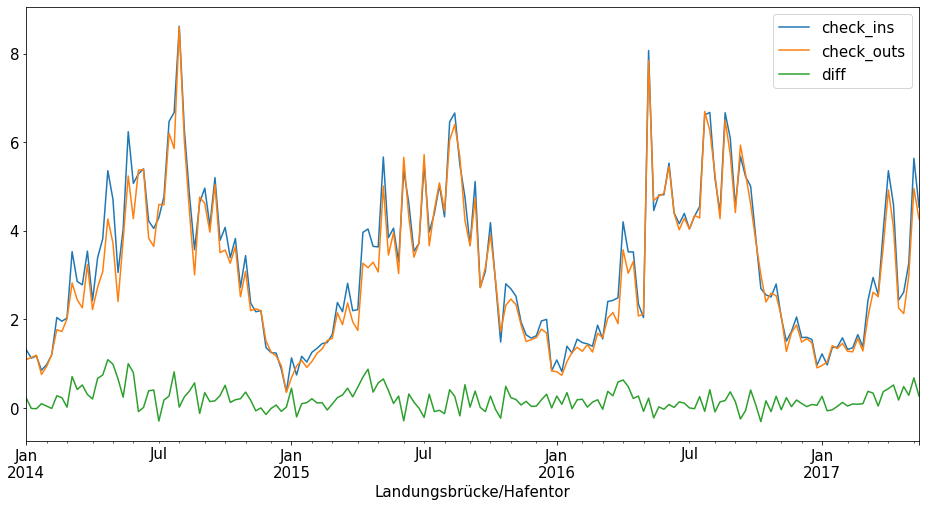

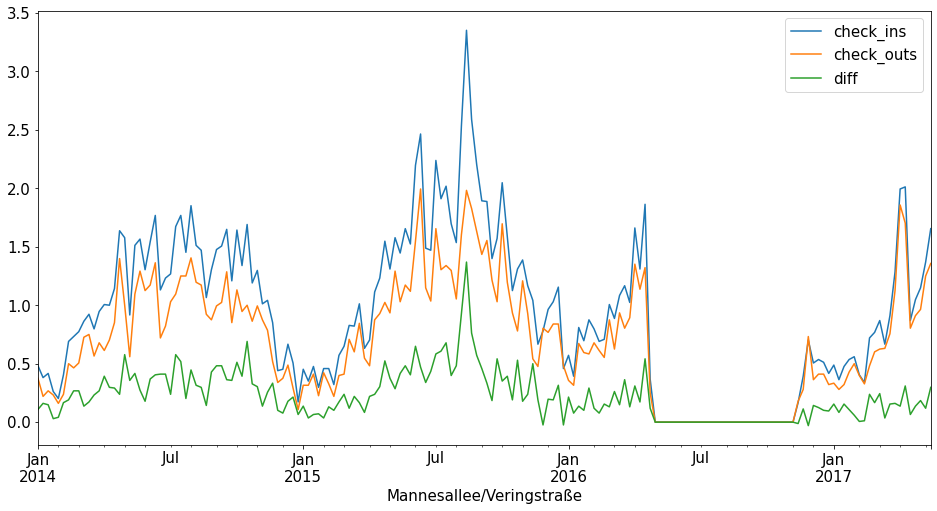

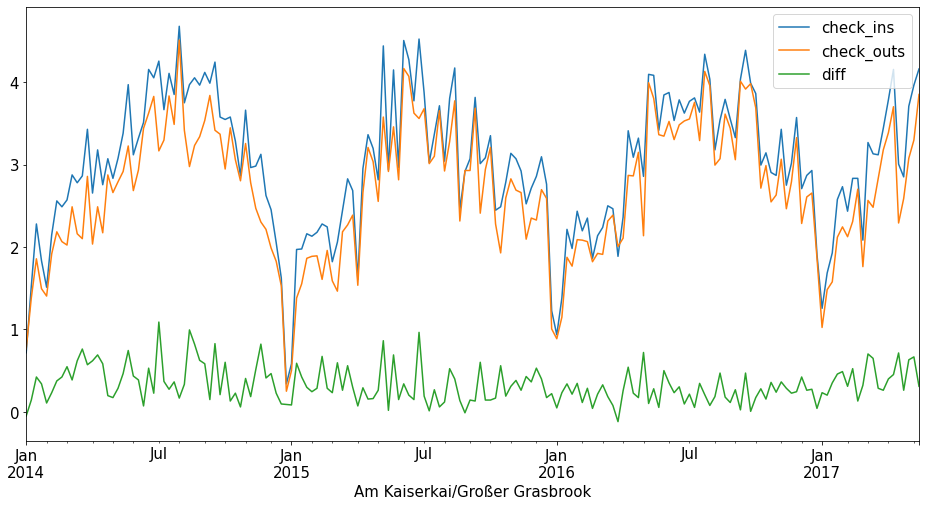

In [25]:
highest_diff = stations_count.tail(5)

for station_name in highest_diff.name:
    tmp = grouped_by_station.get_group(station_name).resample("W").agg("mean")
    ax = tmp.iloc[:-1][["check_ins", "check_outs", "diff"]].plot.line()
    ax.set_xlabel(station_name)
    plt.show()

## Examining sample stations

### Prerequisites for sample selection

* station has to be included in the data set since the beginning (January 2014)
* stations have to be somehow different from another, be it in absolute demand, demand patterns, distance to city centre, etc.

### Interesting features of selected stations

**Am Kaiserkai/Großer Grasbrook**
* is one of the most popular during rush hours
* has the highest overall diff, meaning a great imbalance and surplus in bicycle inventory
* is located close to the city centre
* has a lot of neighbouring stations

**Grindelberg / Bezirksamt Eimsbüttel**
* does not have many strong imbalanced routes but has a negative diff overall
* when comparing mean check-in count of stations, it is right in the middle
* has a medium amount of neighbouring stations

**Barkassenanleger/Mengestraße**
* has an overall diff close to zero (-50, third best)
* is located further away from the city centre and one of the few stations south of the Elbe
* has few neighbouring stations

In [26]:
# stations that are present since the beginning and have a diff within a range of -50 and +50

stations_count[
    (stations_count.name.isin(first_month_stations)) &
    (stations_count["diff"].isin(range(-50,51)))
]

,station_id,name,longitude,latitude,check_outs,check_ins,diff
124,226605,Barkassenanleger/Mengestraße,9.996470,53.499748,7244,7194,-50
48,138385,Lange Reihe / Lohmühlenpark,10.014900,53.559900,107718,107716,-2
64,140802,Landwehr / Ramazan-Avci-Platz,10.037022,53.561109,45239,45273,34


In [27]:
sample_station_a = "Am Kaiserkai/Großer Grasbrook"
sample_station_b = "Grindelberg / Bezirksamt Eimsbüttel"
sample_station_c = "Barkassenanleger/Mengestraße"

sample_stations = [sample_station_a, sample_station_b, sample_station_c]

In [28]:
# Save location of selected sample stations as data set to display in kepler maps

stations[
    stations.name.isin(sample_stations)
].to_csv("../../data/kepler/sample_stations_location.csv", index=False)

In [29]:
stations_count[stations_count.name == sample_station_a]

,station_id,name,longitude,latitude,check_outs,check_ins,diff
71,193238,Am Kaiserkai/Großer Grasbrook,9.992856,53.541838,79570,89269,9699


In [30]:
stations_count[stations_count.name == sample_station_b]

,station_id,name,longitude,latitude,check_outs,check_ins,diff
38,138370,Grindelberg / Bezirksamt Eimsbüttel,9.977824,53.575408,28755,28336,-419


In [31]:
stations_count[stations_count.name == sample_station_c]

,station_id,name,longitude,latitude,check_outs,check_ins,diff
124,226605,Barkassenanleger/Mengestraße,9.99647,53.499748,7244,7194,-50


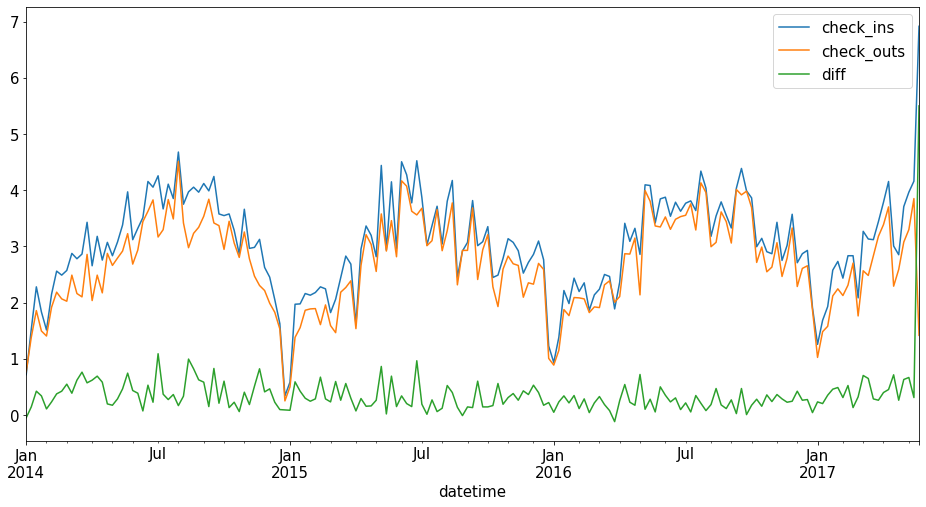

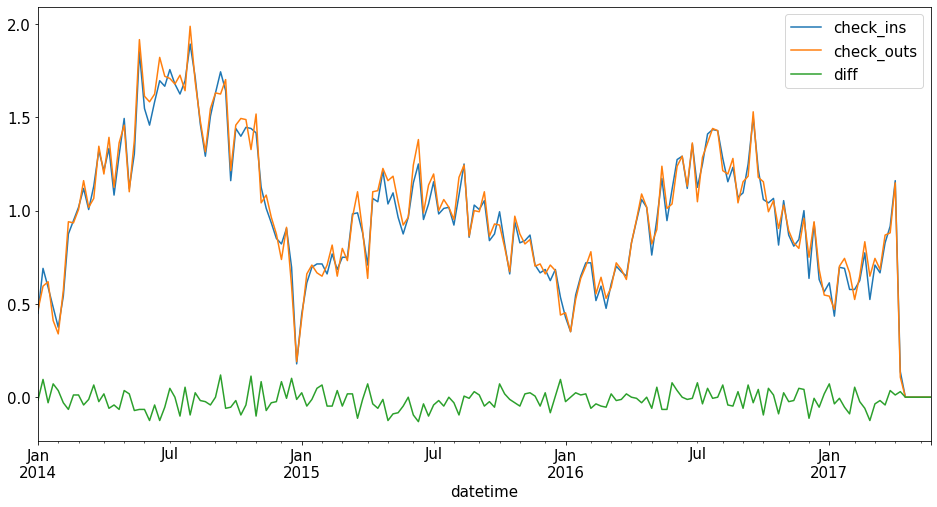

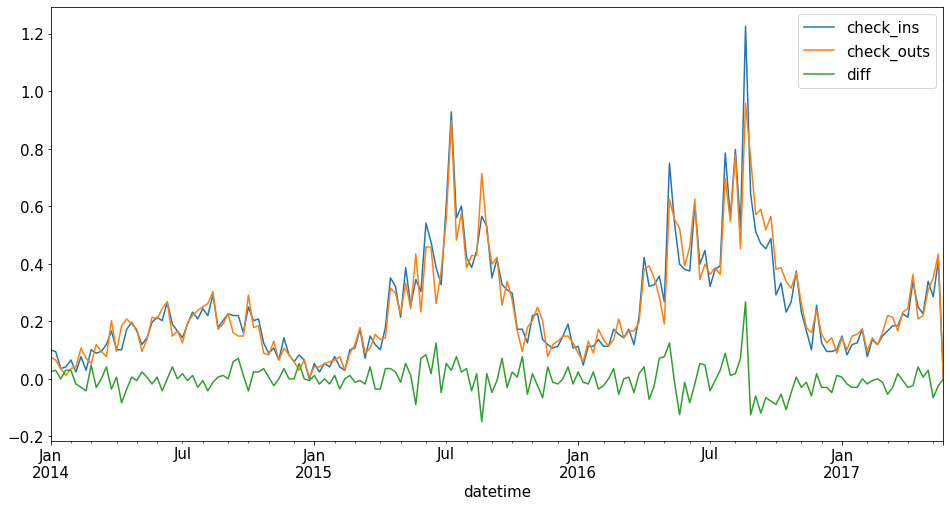

In [32]:
# Plot weekly mean check-ins, check-outs and difference for sample stations

for sample_station in sample_stations:
    tph = trips_per_hour[trips_per_hour.station_name == sample_station][["check_ins", "check_outs", "diff"]]
    tph.resample("W").agg("mean").plot.line()

## Count number of neighbors for each station

A threshold is set at the mean distance of all bicycle trips in the data set.
Station A is a neighbour of station B if it is not further away than the threshold.

In [33]:
neighbour_threshold = trips.distance_in_km.quantile(0.75).round(1)
print("neighbour threshold: % s km"% neighbour_threshold)

neighbour threshold: 2.6 km


In [34]:
# Load previously calculated data set that contains the distances between each pair of stations
distances = np.load("../../calculations/station_distances.npy", allow_pickle=True).item()

def count_neighbours(station):
    count = 0
    neighbours = distances[station.station_id]
    for neighbour_distance in neighbours.values():
        if (neighbour_distance <= neighbour_threshold):
            count = count + 1
    return count - 1 # removes itself as a neighbour


stations_count["neighbour_stations_count"] = stations_count.apply(count_neighbours, axis=1)
stations_count.sample(5)

,station_id,name,longitude,latitude,check_outs,check_ins,diff,neighbour_stations_count
203,256467,Röntgenstraße/Philips,10.012209,53.623481,5118,5124,6,5
17,131653,Zentralbibliothek / Münzstraße,10.008849,53.550332,30840,28332,-2508,60
99,211920,Billstraße/Billhorner Deich,10.042870,53.540103,17551,17439,-112,20
190,253227,Neuländer Kamp/Eurofins,10.004133,53.461651,2150,2149,-1,10
12,131648,Schulterblatt/Eifflerstraße,9.960990,53.562709,144356,144512,156,59


In [35]:
stations_count.sort_values(by="neighbour_stations_count")

,station_id,name,longitude,latitude,check_outs,check_ins,diff,neighbour_stations_count
171,250340,Hugo-Kirchberg-Straße/Tesa,9.985280,53.654290,2541,1985,-556,1
167,247847,Nordalbinger Weg/Paul-Sorge-Straße,9.950095,53.640835,768,1050,282,1
168,247851,Langenhorn Markt/Tangstedter Landstraße,10.016366,53.648757,2636,3080,444,1
197,254728,S Allermöhe/Walter-Rudolphi-Weg,10.158515,53.490126,1202,1151,-51,1
182,252493,Elbchaussee/Teufelsbrück,9.862013,53.547425,3935,4093,158,2
...,...,...,...,...,...,...,...,...
26,131882,Universität / Moorweidenstraße,9.987659,53.563755,57913,58223,310,71
45,138382,Bahnhof Dammtor Süd / Marseiller Straße,9.989630,53.560200,65803,64388,-1415,71
106,213235,St.Petersburger Straße/Bei den Kirchhöfen,9.981839,53.559762,24627,22412,-2215,72
25,131881,Universität / Schlüterstraße,9.986076,53.566972,92286,94215,1929,74


In [36]:
KeplerGl(
    height=700, 
    data={
        "stations_count": stations_count,
    },
    config=eval(open("../../config/map_neighbour_stations.py", "r").read())
)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'bm3aj5l', 'type': …

## Identify most imbalanced pairs overall

In [37]:
# Count all check-outs from A to B by grouping by start station first and end station second
# and counting the entries per group
checkouts = trips[["date_from", "start_station_name", "end_station_name"]].groupby(
    ["start_station_name", "end_station_name"]
).agg("count")
checkouts.rename(columns={"date_from": "checkout_count"}, inplace=True)

# Count all check-ins from A to B by grouping by end station first and start station second
# and counting the entries per group
checkins = trips[["date_until", "end_station_name", "start_station_name"]].groupby(
    ["end_station_name", "start_station_name"]
).agg("count")
checkins.rename(columns={"date_until": "checkin_count"}, inplace=True)

# Merge into one data frame
movements = checkins.merge(checkouts, left_index=True, right_on=["start_station_name", "end_station_name"])

# The difference in inventory is the amount of check-ins minus the amount of check-outs
movements["diff"] = movements["checkin_count"] - movements["checkout_count"]

movements

checkin_count  \
start_station_name       end_station_name                                         
Allende-Platz/Grindelhof Allende-Platz/Grindelhof                          4112   
                         Alsenstraße/Düppelstraße                          1568   
                         Alsterdorf Markt/Evangelische Stiftung              17   
                         Alsterdorfer Straße/Fuhlsbüttler Straße              1   
                         Alsterschwimmhalle/Ifflandstraße                   309   
...                                                                         ...   
Überseering/Mexikoring   Weidestraße/Biedermannplatz                        314   
                         Wiesendamm/Roggenkamp                             1255   
                         Winterhuder Weg/ Zimmerstraße                      138   
                         Zentralbibliothek / Münzstraße                       1   
                         Überseering/Mexikoring                             626   

                                                                  checkout_count  \
start_station_name       end_station_name                                          
Allende-Platz/Grindelhof Allende-Platz/Grindelhof                           4112   
                         Alsenstraße/Düppelstraße                           1705   
                         Alsterdorf Markt/Evangelische Stiftung               17   
                         Alsterdorfer Straße/Fuhlsbüttler Straße               5   
                         Alsterschwimmhalle/Ifflandstraße                    338   
...                                                                          ...   
Überseering/Mexikoring   Weidestraße/Biedermannplatz                         188   
                         Wiesendamm/Roggenkamp                              1172   
                         Winterhuder Weg/ Zimmerstraße                       239   
                         Zentralbibliothek / Münzstraße                        3   
                         Überseering/Mexikoring                              626   

                                                                  diff  
start_station_name       end_station_name                               
Allende-Platz/Grindelhof Allende-Platz/Grindelhof                    0  
                         Alsenstraße/Düppelstraße                 -137  
                         Alsterdorf Markt/Evangelische Stiftung      0  
                         Alsterdorfer Straße/Fuhlsbüttler Straße    -4  
                         Alsterschwimmhalle/Ifflandstraße          -29  
...                                                                ...  
Überseering/Mexikoring   Weidestraße/Biedermannplatz               126  
                         Wiesendamm/Roggenkamp                      83  
                         Winterhuder Weg/ Zimmerstraße            -101  
                         Zentralbibliothek / Münzstraße             -2  
                         Überseering/Mexikoring                      0  

[25088 rows x 3 columns]

In [38]:
# Check that movement is symmetrical

sample_x = "Allende-Platz/Grindelhof"
sample_y = "Alter Wall/Adolphsbrücke"

x_y = movements[movements["diff"] > 0].reset_index()
y_x = movements[movements["diff"] < 0].reset_index()

In [39]:
x_y[(x_y.start_station_name == sample_x) & (x_y.end_station_name == sample_y)]

,start_station_name,end_station_name,checkin_count,checkout_count,diff
0,Allende-Platz/Grindelhof,Alter Wall/Adolphsbrücke,427,422,5


In [40]:
y_x[(y_x.start_station_name == sample_y) & (y_x.end_station_name == sample_x)]

,start_station_name,end_station_name,checkin_count,checkout_count,diff
301,Alter Wall/Adolphsbrücke,Allende-Platz/Grindelhof,422,427,-5


In [41]:
x_y.describe()

,checkin_count,checkout_count,diff
count,11931.000000,11931.000000,11931.000000
mean,337.947448,271.765066,66.182382
std,752.342456,628.797036,166.650384
min,2.000000,1.000000,1.000000
25%,26.000000,16.000000,6.000000
50%,100.000000,70.000000,20.000000
75%,335.500000,261.000000,61.000000
max,19582.000000,15733.000000,4153.000000


In [42]:
y_x.describe()

,checkin_count,checkout_count,diff
count,11931.000000,11931.000000,11931.000000
mean,271.765066,337.947448,-66.182382
std,628.797036,752.342456,166.650384
min,1.000000,2.000000,-4153.000000
25%,16.000000,26.000000,-61.000000
50%,70.000000,100.000000,-20.000000
75%,261.000000,335.500000,-6.000000
max,15733.000000,19582.000000,-1.000000


In [43]:
# Extract movements data for sample stations

def extract_movements(sample_station, filename):
    tmp = movements.loc[[sample_station]].reset_index()
    tmp = tmp.merge(coordinates, left_on="start_station_name", right_index=True, sort=False)
    tmp = tmp.merge(coordinates, left_on="end_station_name", right_index=True, sort=False)
    tmp = tmp.rename(columns={ "start_station_name": "station_x", "end_station_name": "station_y" })
    filename_pos = "../../data/kepler/% s_connections_pos.csv"%filename
    filename_neg = "../../data/kepler/% s_connections_neg.csv"%filename
    tmp[tmp["diff"] >= 0].to_csv(filename_pos, index=False)
    tmp[tmp["diff"] < 0].to_csv(filename_neg, index=False)
    return tmp

#sample_station_a_movements = extract_movements(sample_station_a, "sample_station_a")
#sample_station_b_movements = extract_movements(sample_station_b, "sample_station_b")
#sample_station_c_movements = extract_movements(sample_station_c, "sample_station_c")

In [44]:
# Movement is symmetrical for the whole data set!
# If n bikes arrived at station X from station Y, then n bikes moved from station Y to station X.
# So either all positive or all negative values can be examined.

imbalanced_routes = movements[movements["diff"] > 0]

In [45]:
# Prepare data set for kepler visualisation, adding coordinates

imbalanced_routes.reset_index(inplace=True)
imbalanced_routes = imbalanced_routes.merge(
    coordinates, left_on="start_station_name", right_index=True, sort=False
)
imbalanced_routes = imbalanced_routes.merge(
    coordinates, left_on="end_station_name", right_index=True, sort=False
)
imbalanced_routes.rename(
    columns={ "start_station_name": "station_x", "end_station_name": "station_y" }, 
    inplace=True
)

imbalanced_routes.sample(5)

,station_x,station_y,checkin_count,checkout_count,diff,latitude_x,longitude_x,latitude_y,longitude_y
4966,Holsteinischer Kamp/ Wagnerstraße,Mundsburg / Schürbeker Straße,1786,1300,486,53.574518,10.036608,53.569600,10.027100
3155,Friedensallee/Hegarstraße ( S Bahn Bahrenfeld ),Grindelberg / Bezirksamt Eimsbüttel,9,8,1,53.560260,9.908946,53.575408,9.977824
6442,Landwehr / Ramazan-Avci-Platz,Planetarium/Hindenburgstraße,59,54,5,53.561109,10.037022,53.595950,10.013650
2340,Domstraße/Willy-Brandt-Straße,Emil-Andresen-Straße / Lohkoppelweg,4,1,3,53.547486,9.994057,53.592850,9.952055
905,Bahnhof Dammtor Nord // Theodor-Heuss-Platz,Winterhuder Weg/ Zimmerstraße,719,522,197,53.561400,9.990430,53.575308,10.020450


In [46]:
imbalanced_routes["diff"].describe()

count    11931.000000
mean        66.182382
std        166.650384
min          1.000000
25%          6.000000
50%         20.000000
75%         61.000000
max       4153.000000
Name: diff, dtype: float64

In [47]:
imbalanced_routes["diff"].quantile(0.99)

704.1000000000022

In [48]:
map = KeplerGl(
    height=700,
    data={
        "imbalances": imbalanced_routes,
        "stations": stations,
    },
    config=eval(open("../../config/map_imbalances_overall.py", "r").read())
)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'fx0lhvp', 'type': …

In [49]:
# Top most imbalanced routes overall

imbalanced_routes.sort_values(by="diff", ascending=False).head(15)

,station_x,station_y,checkin_count,checkout_count,diff,latitude_x,longitude_x,latitude_y,longitude_y
10984,Universität / Schlüterstraße,Hallerstraße / Rohtenbaumchaussee,11960,7807,4153,53.566972,9.986076,53.572081,9.988801
791,Bahnhof Altona West / Busbahnhof,Bahrenfelder Straße/Völckersstraße,19582,15733,3849,53.551800,9.933870,53.556897,9.927945
477,Am Kaiserkai/Großer Grasbrook,U-Bahn Baumwall,12607,8889,3718,53.541838,9.992856,53.544279,9.980896
7939,Mönckebergstraße / Steintorwall,Am Kaiserkai/Großer Grasbrook,7787,4213,3574,53.551600,10.005400,53.541838,9.992856
73,Allende-Platz/Grindelhof,U-Bahn Schlump,5166,2577,2589,53.567845,9.982728,53.567991,9.969601
9330,Schleidenstraße/Osterbekstraße,Saarlandstraße/Wiesendamm,15568,12995,2573,53.584582,10.033690,53.588735,10.032680
7287,Mannesallee/Veringstraße,Wilhelmsburger Platz/Zur Schleuse,7153,4630,2523,53.514265,9.987298,53.522794,10.014810
2530,Eiffestrasse/Normannenweg,Berliner Tor / Berlinertordamm,4717,2371,2346,53.552123,10.030364,53.553300,10.024600
1828,Burgstraße/Hammer Landstraße,Berliner Tor / Berlinertordamm,5861,3573,2288,53.555693,10.041298,53.553300,10.024600
7985,Mönckebergstraße / Steintorwall,Unilever/Strandkai,4273,2001,2272,53.551600,10.005400,53.539580,9.993650


## Identify most imbalanced pairs per hour

In [50]:
# Count all check-outs from A to B per hour
hourly_checkouts = trips[["date_from", "start_station_name", "end_station_name"]].groupby(
    [trips.date_from.dt.hour, "start_station_name", "end_station_name"]
).agg("count")
hourly_checkouts.rename(columns={"date_from": "checkout_count"}, inplace=True)
hourly_checkouts

# Count all check-ins from A to B per hour
hourly_checkins = trips[["date_until", "end_station_name", "start_station_name"]].groupby(
    [trips.date_until.dt.hour, "end_station_name", "start_station_name"]
).agg("count")
hourly_checkins.rename(columns={"date_until": "checkin_count"}, inplace=True)
hourly_checkins

# Merge into one data frame
hourly_movements = hourly_checkins.merge(
    hourly_checkouts, left_index=True, right_on=["date_from", "start_station_name", "end_station_name"]
)

# The difference in inventory is the amount of check-ins minus the amount of check-outs
hourly_movements["diff"] = hourly_movements["checkin_count"] - hourly_movements["checkout_count"]

hourly_movements

checkin_count  \
date_from start_station_name       end_station_name                                  
0         Allende-Platz/Grindelhof Allende-Platz/Grindelhof                    112   
                                   Alsenstraße/Düppelstraße                     36   
                                   Alsterschwimmhalle/Ifflandstraße              3   
                                   Am Kaiserkai/Großer Grasbrook                 6   
                                   Amsinckstraße/ Nordkanalbrücke               11   
...                                                                            ...   
23        Überseering/Mexikoring   Schleidenstraße/Osterbekstraße                5   
                                   Südring/Stadthallenbrücke                     2   
                                   Weidestraße/Biedermannplatz                   1   
                                   Wiesendamm/Roggenkamp                        29   
                                   Überseering/Mexikoring                       14   

                                                                     checkout_count  \
date_from start_station_name       end_station_name                                   
0         Allende-Platz/Grindelhof Allende-Platz/Grindelhof                     112   
                                   Alsenstraße/Düppelstraße                      79   
                                   Alsterschwimmhalle/Ifflandstraße              13   
                                   Am Kaiserkai/Großer Grasbrook                  4   
                                   Amsinckstraße/ Nordkanalbrücke                19   
...                                                                             ...   
23        Überseering/Mexikoring   Schleidenstraße/Osterbekstraße                 9   
                                   Südring/Stadthallenbrücke                      4   
                                   Weidestraße/Biedermannplatz                    7   
                                   Wiesendamm/Roggenkamp                          9   
                                   Überseering/Mexikoring                        11   

                                                                     diff  
date_from start_station_name       end_station_name                        
0         Allende-Platz/Grindelhof Allende-Platz/Grindelhof             0  
                                   Alsenstraße/Düppelstraße           -43  
                                   Alsterschwimmhalle/Ifflandstraße   -10  
                                   Am Kaiserkai/Großer Grasbrook        2  
                                   Amsinckstraße/ Nordkanalbrücke      -8  
...                                                                   ...  
23        Überseering/Mexikoring   Schleidenstraße/Osterbekstraße      -4  
                                   Südring/Stadthallenbrücke           -2  
                                   Weidestraße/Biedermannplatz         -6  
                                   Wiesendamm/Roggenkamp               20  
                                   Überseering/Mexikoring               3  

[294352 rows x 3 columns]

In [51]:
# Movement is symmetrical.
# If n bikes arrived at station X from station Y, then n bikes moved from station Y to station X.
# So either all positive or all negative values can be examined.

hourly_imbalances = hourly_movements[hourly_movements["diff"] > 0]

# Add coordinates to display in kepler
hourly_imbalances = hourly_imbalances.merge(
    coordinates, left_on="start_station_name", right_index=True, sort=False
)
hourly_imbalances = hourly_imbalances.merge(
    coordinates, left_on="end_station_name", right_index=True, sort=False
)
hourly_imbalances.rename(
    columns={ "start_station_name": "station_x", "end_station_name": "station_y", "date_from": "hour" }, 
    inplace=True
)

# Reset multiindex for kepler
hourly_imbalances.reset_index(inplace=True)
hourly_imbalances.to_csv("../../data/kepler/stations_hourly_imbalances.csv", index=False)

hourly_imbalances

,date_from,start_station_name,end_station_name,checkin_count,checkout_count,diff,latitude_x,longitude_x,latitude_y,longitude_y
0,0,Allende-Platz/Grindelhof,Am Kaiserkai/Großer Grasbrook,6,4,2,53.567845,9.982728,53.541838,9.992856
1,13,Allende-Platz/Grindelhof,Am Kaiserkai/Großer Grasbrook,23,15,8,53.567845,9.982728,53.541838,9.992856
2,15,Allende-Platz/Grindelhof,Am Kaiserkai/Großer Grasbrook,29,8,21,53.567845,9.982728,53.541838,9.992856
3,16,Allende-Platz/Grindelhof,Am Kaiserkai/Großer Grasbrook,46,8,38,53.567845,9.982728,53.541838,9.992856
4,17,Allende-Platz/Grindelhof,Am Kaiserkai/Großer Grasbrook,137,4,133,53.567845,9.982728,53.541838,9.992856
...,...,...,...,...,...,...,...,...,...,...
133352,23,Nordalbinger Weg/Paul-Sorge-Straße,Nordalbinger Weg/Paul-Sorge-Straße,5,3,2,53.640835,9.950095,53.640835,9.950095
133353,12,Siemersplatz/Kollaustraße,Nordalbinger Weg/Paul-Sorge-Straße,2,1,1,53.600072,9.963929,53.640835,9.950095
133354,13,Siemersplatz/Kollaustraße,Nordalbinger Weg/Paul-Sorge-Straße,3,1,2,53.600072,9.963929,53.640835,9.950095
133355,16,Siemersplatz/Kollaustraße,Nordalbinger Weg/Paul-Sorge-Straße,13,5,8,53.600072,9.963929,53.640835,9.950095


In [52]:
hourly_imbalances["diff"].quantile(0.9)

39.0

## Visualise hourly imbalances for a managable sample

In [53]:
sample_start_date = pd.to_datetime("2016-04-01")
sample_end_date = pd.to_datetime("2016-04-30 23:59:59")
sample_df = trips[trips.date_from.between(sample_start_date, sample_end_date)]

hourly_checkouts = sample_df[["date_from", "start_station_name", "end_station_name"]].groupby(
    [sample_df.date_from.dt.hour, "start_station_name", "end_station_name"]
).agg("count")
hourly_checkouts.rename(columns={"date_from": "checkout_count"}, inplace=True)
hourly_checkouts

hourly_checkins = sample_df[["date_until", "end_station_name", "start_station_name"]].groupby(
    [sample_df.date_until.dt.hour, "end_station_name", "start_station_name"]
).agg("count")
hourly_checkins.rename(columns={"date_until": "checkin_count"}, inplace=True)
hourly_checkins

hourly_movements = hourly_checkins.merge(
    hourly_checkouts, left_index=True, right_on=["date_from", "start_station_name", "end_station_name"]
)

hourly_movements["diff"] = hourly_movements["checkin_count"] - hourly_movements["checkout_count"]

hourly_imbalances = hourly_movements[hourly_movements["diff"] > 0]

hourly_imbalances = hourly_imbalances.merge(
    coordinates, left_on="start_station_name", right_index=True, sort=False
)
hourly_imbalances = hourly_imbalances.merge(
    coordinates, left_on="end_station_name", right_index=True, sort=False
)
hourly_imbalances.rename(
    columns={ "start_station_name": "station_x", "end_station_name": "station_y", "date_from": "hour" }, 
    inplace=True
)

hourly_imbalances.reset_index(inplace=True)
hourly_imbalances.to_csv("../../data/kepler/stations_hourly_imbalances_sample.csv", index=False)

In [54]:
hourly_imbalances

,date_from,start_station_name,end_station_name,checkin_count,checkout_count,diff,latitude_x,longitude_x,latitude_y,longitude_y
0,0,Allende-Platz/Grindelhof,Allende-Platz/Grindelhof,2,1,1,53.567845,9.982728,53.567845,9.982728
1,3,Allende-Platz/Grindelhof,Allende-Platz/Grindelhof,2,1,1,53.567845,9.982728,53.567845,9.982728
2,9,Allende-Platz/Grindelhof,Allende-Platz/Grindelhof,4,3,1,53.567845,9.982728,53.567845,9.982728
3,11,Allende-Platz/Grindelhof,Allende-Platz/Grindelhof,3,2,1,53.567845,9.982728,53.567845,9.982728
4,15,Allende-Platz/Grindelhof,Allende-Platz/Grindelhof,11,7,4,53.567845,9.982728,53.567845,9.982728
...,...,...,...,...,...,...,...,...,...,...
14752,18,Dürerstraße/Beslerplatz- S Bahn Othmarschen,DESY/Notkestraße,12,1,11,53.560395,9.887159,53.574537,9.878527
14753,19,Dürerstraße/Beslerplatz- S Bahn Othmarschen,DESY/Notkestraße,3,1,2,53.560395,9.887159,53.574537,9.878527
14754,10,Hugo-Kirchberg-Straße/Tesa,Langenhorn Markt/Tangstedter Landstraße,3,1,2,53.654290,9.985280,53.648757,10.016366
14755,18,Langenhorn Markt/Tangstedter Landstraße,Langenhorn Markt/Tangstedter Landstraße,3,2,1,53.648757,10.016366,53.648757,10.016366


In [55]:
map = KeplerGl(
    height=700,
    data={"hourly_imbalances": hourly_imbalances[hourly_imbalances.date_from.isin([17,18])]},
    config=eval(open("../../config/map_imbalances_hourly.py", "r").read())
)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '9mn0ofu', 'type': …

## Count and visualise top routes overall

In [56]:
# Count occurrence of each route (not symmetrically)
routes_count = trips.value_counts(subset=["start_station_name", "end_station_name"], sort=True).to_frame()
routes_count.reset_index(inplace=True)

# Rename column
routes_count.rename(columns={0: "count"}, inplace=True)

# Aggregate symmetrically
sorted_routes_count = np.sort(routes_count[["start_station_name", "end_station_name"]], axis=1)
routes_count = routes_count.groupby(
    [sorted_routes_count[:,0], sorted_routes_count[:,1]]
)["count"].sum().reset_index()

# Rename columns
routes_count.rename(columns={"level_0": "station_x", "level_1": "station_y"}, inplace=True)
routes_count.head(5)

,station_x,station_y,count
0,Allende-Platz/Grindelhof,Allende-Platz/Grindelhof,4112
1,Allende-Platz/Grindelhof,Alsenstraße/Düppelstraße,3273
2,Allende-Platz/Grindelhof,Alsterdorf Markt/Evangelische Stiftung,34
3,Allende-Platz/Grindelhof,Alsterdorfer Straße/Fuhlsbüttler Straße,6
4,Allende-Platz/Grindelhof,Alsterschwimmhalle/Ifflandstraße,647


In [57]:
# Add coordinates to station pairs

routes = pd.merge(routes_count, stations, left_on="station_x", right_on="name", how="left", sort=False)
routes.rename(columns={"latitude": "latitude_x",  "longitude": "longitude_x"}, inplace=True)

routes = pd.merge(routes, stations, left_on="station_y", right_on="name", how="left", sort=False)
routes.rename(columns={"latitude": "latitude_y", "longitude": "longitude_y" }, inplace=True)

routes.drop(columns=["station_id_x", "name_x", "station_id_y", "name_y"], inplace=True)
routes.head(5)

,station_x,station_y,count,longitude_x,latitude_x,longitude_y,latitude_y
0,Allende-Platz/Grindelhof,Allende-Platz/Grindelhof,4112,9.982728,53.567845,9.982728,53.567845
1,Allende-Platz/Grindelhof,Alsenstraße/Düppelstraße,3273,9.982728,53.567845,9.948345,53.563037
2,Allende-Platz/Grindelhof,Alsterdorf Markt/Evangelische Stiftung,34,9.982728,53.567845,10.023946,53.612091
3,Allende-Platz/Grindelhof,Alsterdorfer Straße/Fuhlsbüttler Straße,6,9.982728,53.567845,10.032000,53.620000
4,Allende-Platz/Grindelhof,Alsterschwimmhalle/Ifflandstraße,647,9.982728,53.567845,10.022148,53.560781


In [58]:
routes.tail(5)

,station_x,station_y,count,longitude_x,latitude_x,longitude_y,latitude_y
13640,Winterhuder Weg/ Zimmerstraße,Zentralbibliothek / Münzstraße,249,10.020450,53.575308,10.008849,53.550332
13641,Winterhuder Weg/ Zimmerstraße,Überseering/Mexikoring,377,10.020450,53.575308,10.024745,53.601619
13642,Zentralbibliothek / Münzstraße,Zentralbibliothek / Münzstraße,789,10.008849,53.550332,10.008849,53.550332
13643,Zentralbibliothek / Münzstraße,Überseering/Mexikoring,4,10.008849,53.550332,10.024745,53.601619
13644,Überseering/Mexikoring,Überseering/Mexikoring,626,10.024745,53.601619,10.024745,53.601619


In [59]:
pt_stations = gpd.read_file("../../data/esri/pt_stations.geojson")
map = KeplerGl(
    height=700,
    data={"routes": routes, "pt_stations": pt_stations, "stations": stations},
    #config=eval(open("config/map_route_popularity.py", "r").read())
)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'routes':                             station_x  \
0            Allende-Platz/Grindelhof   
1  …

In [60]:
sorted_routes = routes.sort_values(by="count", ascending=False).reset_index()
sorted_routes.drop(columns="index", inplace=True)
sorted_routes.head(15)

,station_x,station_y,count,longitude_x,latitude_x,longitude_y,latitude_y
0,Bahnhof Altona West / Busbahnhof,Bahrenfelder Straße/Völckersstraße,35315,9.933870,53.551800,9.927945,53.556897
1,Saarlandstraße/Wiesendamm,Schleidenstraße/Osterbekstraße,28563,10.032680,53.588735,10.033690,53.584582
2,Mundsburg / Schürbeker Straße,Winterhuder Weg/ Zimmerstraße,22710,10.027100,53.569600,10.020450,53.575308
3,Am Kaiserkai/Großer Grasbrook,U-Bahn Baumwall,21496,9.992856,53.541838,9.980896,53.544279
4,Krausestraße/Eilbektal,Lortzingstraße/Friedrichsberger Straße,21366,10.058237,53.576238,10.049568,53.573588
5,Am Kaiserkai/Großer Grasbrook,Landungsbrücke/Hafentor,20317,9.992856,53.541838,9.972300,53.545700
6,Hallerstraße / Rohtenbaumchaussee,Universität / Schlüterstraße,19767,9.988801,53.572081,9.986076,53.566972
7,Eppendorfer Baum / Isestraße,Martinistraße / Haupteingang Klinikum,19511,9.984410,53.583200,9.975715,53.588918
8,Kellinghusenstraße / Loogeplatz,Martinistraße / Haupteingang Klinikum,18974,9.991125,53.588516,9.975715,53.588918
9,Jarrestraße / Rambatzweg,Mundsburg / Schürbeker Straße,18640,10.021100,53.584000,10.027100,53.569600


In [61]:
sorted_routes.describe()

,count,longitude_x,latitude_x,longitude_y,latitude_y
count,13645.000000,13645.000000,13645.000000,13645.000000,13645.000000
mean,557.418688,9.994009,53.564077,9.998526,53.564850
std,1312.619420,0.043241,0.022581,0.041571,0.022582
min,1.000000,9.862013,53.447625,9.862013,53.447625
25%,24.000000,9.965669,53.551600,9.970330,53.551000
50%,132.000000,9.991400,53.560200,9.997140,53.563755
75%,530.000000,10.022685,53.577579,10.027100,53.580004
max,35315.000000,10.220000,53.654290,10.220000,53.654290


In [62]:
sorted_routes["count"].quantile(0.9)

1463.0

In [63]:
sorted_routes["count"].quantile(0.99)

5868.959999999966

In [64]:
sorted_routes["count"].median()

132.0

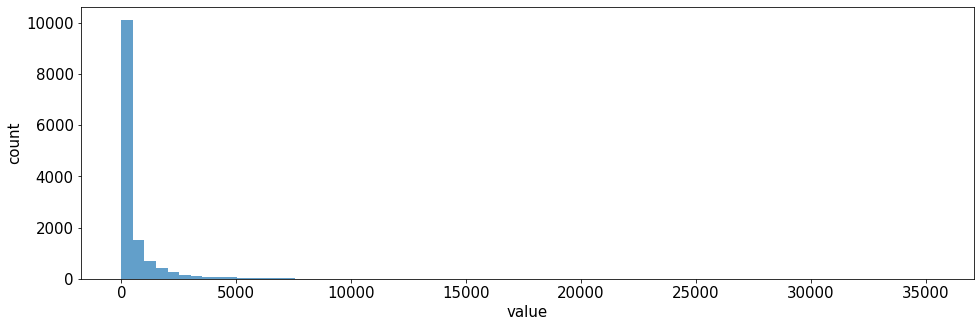

In [65]:
plt.rcParams["figure.figsize"] = (16,5)
plt.hist(sorted_routes["count"], 70, density=False, alpha=0.7)
plt.xlabel("value")
plt.ylabel("count")
plt.show()

In [66]:
top_routes = sorted_routes[sorted_routes["count"] >= sorted_routes["count"].quantile(0.9)]

In [67]:
top_routes.describe()

,count,longitude_x,latitude_x,longitude_y,latitude_y
count,1367.000000,1367.000000,1367.000000,1367.000000,1367.000000
mean,3329.213606,9.991065,53.561967,9.991554,53.561969
std,2771.709042,0.033146,0.020678,0.032524,0.020839
min,1463.000000,9.862013,53.447625,9.887159,53.447625
25%,1829.000000,9.969214,53.552244,9.969250,53.552244
50%,2445.000000,9.989710,53.561109,9.987659,53.562709
75%,3729.500000,10.014402,53.575491,10.014900,53.575308
max,35315.000000,10.206105,53.654290,10.220000,53.648757
